*** This script runs the previously built permit subtype Naive Bayes models to classify service requests. ***

*** Additionally, it also uploads the classification to Buildzoom's database.***


General declarations, including used libraries, support and plotting packages.
Python version 2.7+ must be installed along with the following packages:
os (built-in), numpy, pandas, nltk (Natural Language Processing Toolkit), codecs, sklearn (statistical learning package), mpld3, MySQLdb, pylab, csv, string, matplotlib (plotting), seaborn (plotting), pickle (to save clusters and other data objects).

In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
import MySQLdb
import pandas.io.sql as sql
import matplotlib.pyplot as plt
import pylab as py
import csv
import string
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
from sklearn.externals import joblib
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from pystruct.learners import NSlackSSVM
from pystruct.models import MultiLabelClf
from collections import defaultdict

import seaborn as sns
import pickle

sns.set(style="white", color_codes=True)

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

stopwords=set(unicode("system john american james hbcode thomas david michael robert subtype richard permit building none america rochester william needs brother jessica give like send estimate im youre chat details regarding hi available email call please interested contact looking project need job phone work so some somebody somehow someone something sometime sometimes somewhat somewhere soon sorry specified specify specifying still sub such sup sure t's take taken tell tends th than thank thanks thanx that that's thats the their theirs them themselves then thence there there's thereafter thereby therefore therein theres thereupon these they they'd they'll they're they've think third this thorough thoroughly those though three through throughout thru thus to together too took toward towards tried tries truly try trying twice two un under unfortunately unless unlikely until unto up upon us use used useful uses using usually value various very via viz vs want wants was wasn't way we we'd we'll we're we've welcome well went were weren't what what's whatever when whence whenever where where's whereafter whereas whereby wherein whereupon wherever whether which while whither who who's whoever whole whom whose why will willing wish with within without won't wonder would wouldn't yes yet you you'd you'll you're you've your yours yourself yourselves zero a about above after again against all am an and any are aren't as at be because been before being below between both but by can can't cannot could couldn't did didn't do does doesn't doing don't down during each few for from further had hadn't has hasn't have haven't having he he'd he'll he's her here here's hers herself him himself his how how's i i'd i'll i'm i've if in into is isn't it it's its itself let's me more most mustn't my myself no nor not of off on one once only or other ought our ours ourselves out over own same shan't she she'd she'll she's should shouldn't so some such than that that's the their theirs them themselves then there there's these they they'd they'll they're they've this those through to too under until up very was wasn't we we'd we'll we're we've were weren't what what's when when's where where's which while who who's whom why why's with won't would wouldn't you you'd you'll you're you've your yours yourself yourselves").split())


General functions for reading data, doing cluster to keyword mapping and text pre-processing.

In [2]:
# Read Data from BuildZoom service requests
def read_c(input_file):
    with open(input_file, 'rU') as f:
        reader = csv.reader(f,delimiter='\t')
        for row in reader:
            text=row
    return text

# Function to read words associated to permit subtypes
# Input: file_name
# Output: list of identifier for each trade/permit type (label), list of 'synonym' words for each permit subtype. 
def read_words(input_file):
    label=[]
    words=[]
    with open(input_file, 'rU') as f:
        reader = csv.reader(f,delimiter='\n')
        # For each row in the file, read the job_values and the associated strings. 
        for row in reader:
            row=row[0].split(',')
            label.append(row.pop(0))
            temp=[]
            for x in row:
                x=x.lower()
                x=x.replace('"','')
                x=x.replace(' ','')
                if x != '':
                    temp.append(x)
            words.append(temp)
    return label,words

# Function to join text for a given list. 
# Inputs: list with strings
def join_txt(x):
    content = ' '.join(filter(None,x))
    return content

# Text pre-processing function, that also applies the Snowball stemmer to each word
# This function's only difference compared to content2tokens is the use of the stemmer. 
# Filter out spaces, punctuation, unnecessary whitespaces. 
# Any stop-word is also removed
# Additionally, this function also removes any word smaller than 4 characters
# Inputs: list with string for each building permit
def content2stems(s):
    # Initialize Snowball stemmer
    stemmer = SnowballStemmer("english")
    # Transform all letters to lower-case
    content = s.lower()
    # Remove periods
    content = content.replace('.', ' ')    
    # Split words
    content = ' '.join(content.split())
    # Remove punctuation
    for c in content:
        if c in string.punctuation or c.isdigit():
            content=content.replace(c," ")
    
    # Split words into a list
    content = content.split() 
    # Filter words from the stoplist
    content = filter(lambda w: w not in stopwords, content)  
    # Filter words smaller than 3 characters
    content = filter(lambda w: len(w) > 3, content)
    # Apply Snowball stemmer to words
    content = [stemmer.stem(t) for t in content]    
    return content

Read service requests from sql database and build the appropriate text object and save service requests id. Also read the labels for the subtype.

In [3]:
# Host, username, password, database to connect
host='db.dev.buildzoom.com'
username='new'
passwr='bzdb123zoom'
db='bzdb'
# Fetch a subset of the service request data with status >= 1
f = open('s_request_query.txt', 'r')
query=f.read()
# Open database connection
connect = MySQLdb.connect(host,username,passwr,db)
s_requests = sql.read_sql(query, connect)
# Concatenate the service request text
requests_text=s_requests.title+' '+s_requests.description
requests_text=map(lambda x: unicode(x,errors='ignore'),requests_text)
# Save ids for each service request
requests_ids = s_requests.nid
# Close connection to database
connect.close()
# Read building permit subtypes keywords and stem them.
keyword_label,keywords=read_words('taxonomy_cluster_keywords.csv')
# Turn all label subtypes to lower_case
keyword_label=map(lambda x: x.lower(),keyword_label)

Read all service requests to be classified from a file, also read the labels for the subtypes.

*** Only run this code if you want to work with service requests that were previously saved to a file. ***

Note that, in this case, request ids could be missing.

In [5]:
file_name='S_Requests.tsv'
requests_text=read_c('./Data/S_Requests.tsv')
requests_text=map(lambda x : unicode(x, errors='ignore'),requests_text)

# Read building permit subtypes keywords and stem them.
keyword_label,keywords=read_words('taxonomy_cluster_keywords.csv')
# Turn all label subtypes to lower_case
keyword_label=map(lambda x: x.lower(),keyword_label)

Open the previously save terms from the vectorization over permit corpus and then build the tf/idf for the classification.

In [4]:
# Open lexicon terms want to use them from a previously saved file.
with open('./NB_Classifiers/permit_terms.pickle') as f:
    terms= pickle.load(f)

terms=terms[0]
# Build tf/idf matrix
tfidf_vectorizer = TfidfVectorizer(vocabulary=terms, stop_words=stopwords,
                                   use_idf=True, tokenizer=content2stems,
                                   decode_error='ignore',ngram_range=[1,1])
tfidf_matrix = tfidf_vectorizer.fit_transform(requests_text)

Run the Naive Bayes_Classifiers to classify the service requests.

In [5]:
classification=[]
# Run the Naive Bayes classifier for each subtype
for i, key in enumerate(keyword_label):
    # Read the NB classifiers
    cls=joblib.load('./NB_Classifiers/NB_'+str(key)+'.pkl')
    
    # Run the classifiers across the service requests
    classification.append(cls.predict(tfidf_matrix))
    
classification=np.array(classification)
classification=np.matrix.transpose(classification)
classification=pd.DataFrame(classification,columns=keyword_label)

Step done just to verify/play around with classification

In [6]:
m=1755
t=np.where(classification.iloc[m,:]==1)[0]
for key in t:
    print(keyword_label[key])
    
print (requests_text[m])

plumbing
plumbing up to code Hi! I am Sergio Quinrtero. I am looking for a licensed professional to do plumbing. I need to get the plumbing up to code, I had people working already,  but nobody finished the job. If you are interested and available for this project, please contact me via phone or use the BuildZoom messaging system. Thanks!


Print out the distribution for the classifications

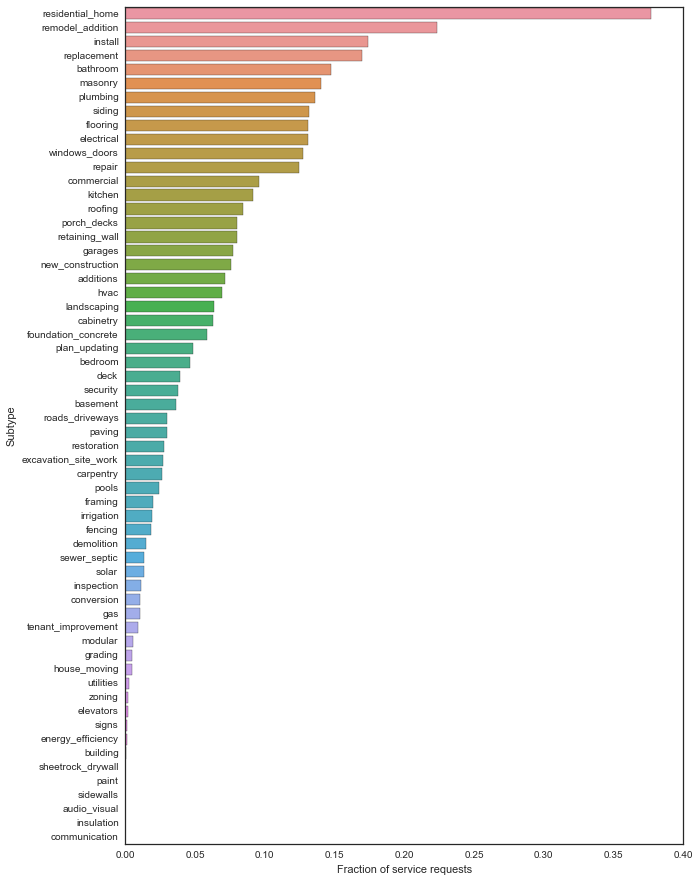

In [7]:
# Plot showing the fraction of times each subtype appears in a service request. 
f, ax = plt.subplots(figsize=(10, 15))
subtype_count=pd.DataFrame(classification.sum(axis=0),columns=['Count'])/len(requests_text)
subtype_count=subtype_count.sort(['Count'],ascending=False).transpose()
sns.barplot(data=subtype_count,orient='h');
plt.xlabel('Fraction of service requests')
plt.ylabel('Subtype')
plt.savefig('./NB_Classifiers/Classification/SRequests_Classification.png')

Write the classification dataframe into Buildzoom's sql database.

In [8]:
# Add service request ids to the pandas dataframe
classification.insert(0,'service_request_id',requests_ids)
# Host, username, password, database to connect
host='db.dev.buildzoom.com'
username='new'
passwr='bzdb123zoom'
db='bzdb'
# Open connection
connect = MySQLdb.connect(host,username,passwr,db)
# Write the table
classification.to_sql(con=connect, name='service_requests_classification', if_exists='append', 
                      flavor='mysql', index=False)
connect.close()